# The idea is to do the following

1. Import the data
2. Shuffle the rows
3. Fix a protein name for now
4. Drop all NaN
5. Take the top 2000 rows as training data
6. Take the last 1000 rows as test data
8. Compute the absolute error, i.e. MSE / L2 norm
9. Try a number of different parameterisations and covariance models

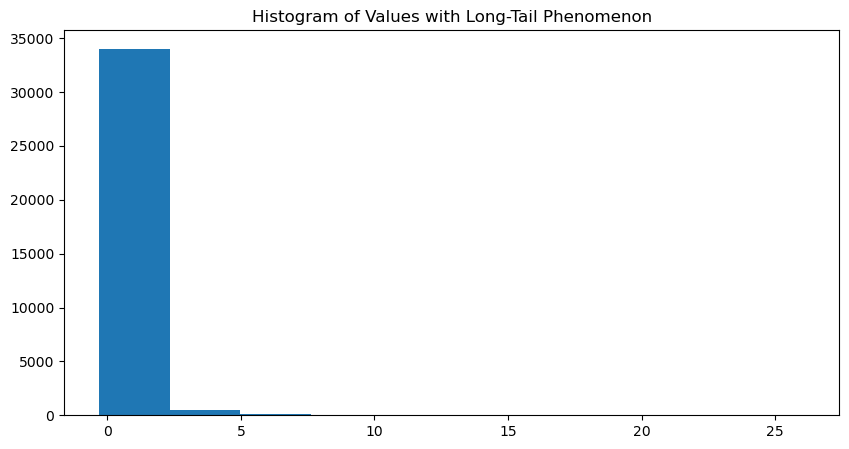

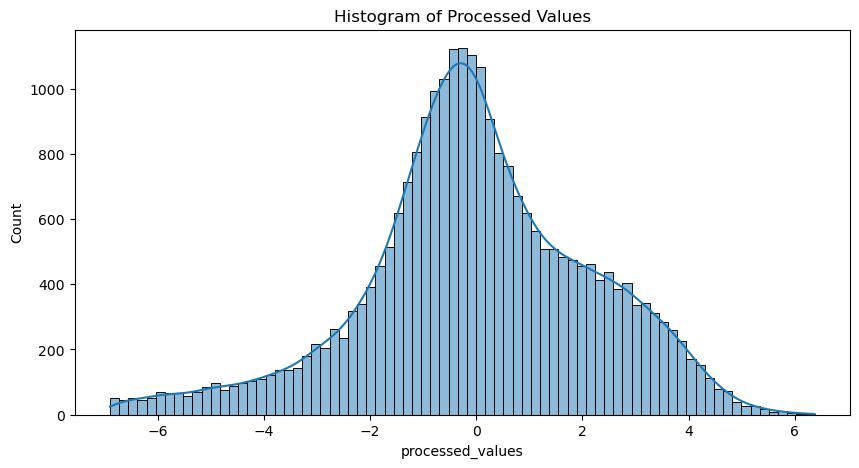

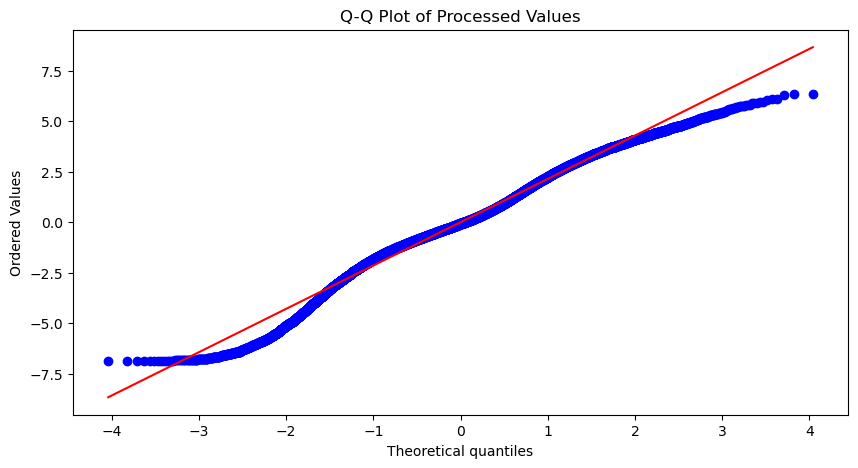

Skewness: -0.28763995829651756
K-S test statistics: 0.1728776803728942, p-value: 0.0
Shapiro-Wilk test statistics: 0.9862984418869019, p-value: 3.433181237595802e-43


/opt/anaconda3/envs/research/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [25]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the file path
file_path = "/Users/cui/Library/CloudStorage/OneDrive-YaleUniversity/0 High-Dim Spatial/hubmap/ann/B009A_22_03_03_Skywalker_reg001_compensated_ann.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
# print(df)

# shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# pick a protein and drop the rows with missing values
protein = 'Synapto'

df = df.dropna(subset=[protein])

# Graphical Analysis
# Histogram
plt.figure(figsize=(10, 5))
# sns.histplot(df[protein], kde=True)
plt.hist(df[protein])
plt.title('Histogram of Values with Long-Tail Phenomenon')
plt.show()


# apply log(\cdot + 1) to avoid the long-tail phenomenon
df[protein] = np.log(df[protein] - df[protein].min()*1.0001) # Note, this is only meaningful if you're sure that min is negative.
df = df.drop(df[df[protein] < -10].index)
df[protein] = df[protein] - df[protein].mean()

# Assuming 'df' is your DataFrame and 'processed_values' is your transformed column

df['processed_values'] = df[protein]
 
# Graphical Analysis
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['processed_values'], kde=True)
plt.title('Histogram of Processed Values')
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 5))
stats.probplot(df['processed_values'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Processed Values')
plt.show()

# Statistical Tests
# Skewness
skewness = stats.skew(df['processed_values'])
print(f'Skewness: {skewness}')

# Kolmogorov-Smirnov test
ks_stat, ks_pvalue = stats.kstest(df['processed_values'], 'norm')
print(f'K-S test statistics: {ks_stat}, p-value: {ks_pvalue}')

# Shapiro-Wilk test
shapiro_stat, shapiro_pvalue = stats.shapiro(df['processed_values'])
print(f'Shapiro-Wilk test statistics: {shapiro_stat}, p-value: {shapiro_pvalue}')


# If the processed data shows a more bell-shaped histogram, aligns more closely with the line in the Q-Q plot, has a skewness near 0, and passes the normality tests (high p-value), it suggests that the transformation was effective in mitigating the long-tail phenomenon.

# Even the histogram looks better than before, the hypothesis tests still say that the long-tail has not been completely solved.


In [2]:
import numpy as np
import gstools as gs

# we normalise x and y so that the grid is approximately 1 by 1

df['x'] = df['x']/df['x'].max()
df['y'] = df['y']/df['y'].max()

# Let x and y be the your collections of x and y locations
x = df['x']  
y = df['y']  

# pick the training data set
df_train = df.head(2000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]


# define the covariance model - gaussian
cov_model = gs.Gaussian(
    # dim=2, len_scale=1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
    dim=2, len_scale=0.1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
)

# grid definition for output field
gridx = np.arange(0.0, 1.05, 0.05)
gridy = np.arange(0.0, 1.05, 0.05)

# perform the kriging and plot
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)

/opt/anaconda3/envs/research/lib/python3.11/site-packages/gstools/field/plot.py:406: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


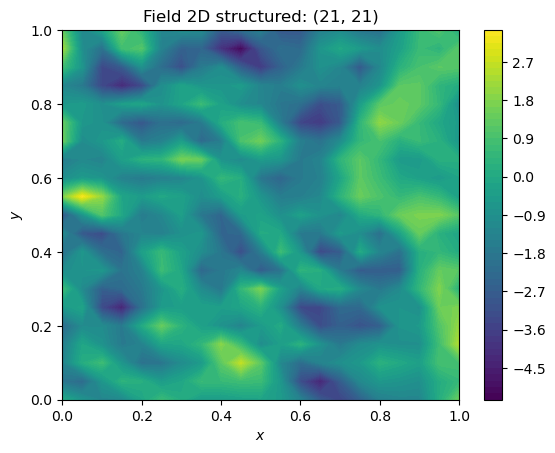

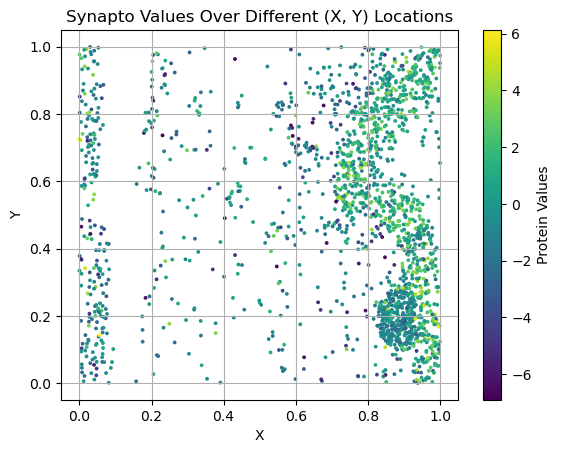

In [3]:
import matplotlib.pyplot as plt

# let us exhibit the two figure, the prediction and the original collection of values

EDK.structured([gridx, gridy])
EDK.plot()
plt.show()

# Plot the Synapto values over different (x, y) locations
# plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, c=df_train[protein], cmap='viridis', s=3)  # Using 'viridis' colormap for better visualization
plt.colorbar(label='Protein Values')  # Add colorbar to show Synapto values
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synapto Values Over Different (X, Y) Locations')
plt.grid(True)
plt.show()


In [4]:
# Alternative methods for dealing with long tail follow.

# import pandas as pd
# import numpy as np
# from scipy import stats

# # Example data frame with a long-tail distribution
# np.random.seed(42)
# data = np.random.lognormal(mean=0, sigma=1, size=1000)
# df = pd.DataFrame(data, columns=['values'])

# # Log Transformation
# df['log_values'] = np.log(df['values'] + 1)  # adding 1 to avoid log(0)

# # Square Root Transformation
# df['sqrt_values'] = np.sqrt(df['values'])

# # Box-Cox Transformation (only for positive values)
# df['boxcox_values'], _ = stats.boxcox(df['values'])

# # Trimming / Winsorizing (e.g., limiting the extreme values to the 95th percentile)
# df['winsorized_values'] = stats.mstats.winsorize(df['values'], limits=[0, 0.05])

# # Binning
# df['binned_values'] = pd.cut(df['values'], bins=10, labels=False)  # 10 equal-length bins

# df.head()

# # Plot histogram using the DataFrame's 'data' column
# plt.hist(df['values'], bins=30)  # Adjust the number of bins as needed
# plt.show()

# plt.hist(df['log_values'], bins=30)  # Adjust the number of bins as needed
# plt.show()

# plt.hist(df['sqrt_values'], bins=30)  # Adjust the number of bins as needed
# plt.show()

# plt.hist(df['winsorized_values'], bins=30)  # Adjust the number of bins as needed
# plt.show()

# plt.hist(df['binned_values'], bins=30)  # Adjust the number of bins as needed
# plt.show()

x_unseen = df_cleaned[3001:4000]['x']
y_unseen = df_cleaned[3001:4000]['y']
predictions,sigma = EDK([x_unseen,y_unseen])
truth = df_cleaned[3001:4000][protein]

In [5]:
x_test = df.tail(1000)['x']
y_test = df.tail(1000)['y']
val_true = df.tail(1000)[protein]
val_pred,sigma = EDK([x_test,y_test])

# At this point, I write a function to compute the absolute error of the prediction. 

In [6]:
from sklearn.metrics import mean_squared_error

# Assuming y_true are the true values and y_pred are the predicted values
# Calculate mean squared error (MSE)
mse = mean_squared_error(val_true, val_pred)

# Calculate variance of the true values
variance = np.var(val_true)

# Calculate normalized MSE
normalized_mse = mse / variance

print("Normalized MSE:", normalized_mse)

Normalized MSE: 0.8715600732536661


# This MSE is too high.  Our goal is putting it down to less than 0.1. Indeed, we can go ahead and streamline this into a function, for which we can modify the parameters more easily. 

In [7]:
# pick the training data set
df_train = df.head(1000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.tail(100)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]

# define the covariance model - gaussian
cov_model = gs.Gaussian(
    # dim=2, len_scale=0.23, var=0.001, nugget=0.01
    dim=2, len_scale=0.1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
)

# perform the kriging
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)

val_pred,sigma = EDK([x_test,y_test])

# Calculate variance of the true values
mse = mean_squared_error(val_true, val_pred)

# Calculate normalized MSE
variance = np.var(val_true)
normalized_mse = mse / variance

print("Normalized MSE:", normalized_mse)

Normalized MSE: 0.8197475123928074


# What am I supposed to do now?  The MSE just always stays high! 

# Here is an idea: I can iterate through a variety of different possible choices. 

In [8]:
%%time

# Assuming y_true are the true values and y_pred are the predicted values
# Define parameter choices

parameters = (0.1, 0.55, 0.0, 0.55, 0.05)

len_scale_choices = np.arange(0.05, 1.01, 0.05).tolist()
anis_choices = np.arange(0.05, 1.01, 0.5).tolist()
angles_choices = np.arange(-0.5, 0.5, 0.5).tolist()
var_choices = np.arange(0.05, 1.01, 0.5).tolist()
nugget_choices = np.arange(0.05, 1.01, 0.5).tolist()


counter = 0
best_params = None
best_normalized_mse = float('inf')

# Loop through parameter choices
for len_scale in len_scale_choices:
    for anis in anis_choices:
        for angles in angles_choices:
            for var in var_choices:
                for nugget in nugget_choices:
                    # define the covariance model - gaussian
                    cov_model = gs.Gaussian(
                        # dim=2, len_scale=0.23, var=0.001, nugget=0.01
                        dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
                    )
                    
                    # perform the kriging
                    EDK = gs.krige.Simple(
                        model=cov_model, 
                        cond_pos=(x_train, y_train), 
                        cond_val=val_train,
                    )
                    val_pred,sigma = EDK([x_test,y_test])

                    # Compute MSE for current parameter combination
                    mse = mean_squared_error(val_true, val_pred)
                    # Compute variance of the true values
                    variance = np.var(val_true)
                    # Compute normalized MSE
                    normalized_mse = mse / variance
                    counter = counter +1
                    # print(len_scale, anis, angles, var, nugget)
                    # print(normalized_mse)
                    # Compare with best normalized MSE so far
                    if normalized_mse < best_normalized_mse:
                        best_normalized_mse = normalized_mse
                        best_params = (len_scale, anis, angles, var, nugget)

print("Best parameters:", best_params)
print("Best normalized MSE:", best_normalized_mse)
print(counter)

Best parameters: (0.15000000000000002, 0.55, -0.5, 0.55, 0.05)
Best normalized MSE: 0.8176585545752364
320
CPU times: user 25min 3s, sys: 6min 45s, total: 31min 48s
Wall time: 2min 48s


# The above gives us a rough initial estimate of the best paramter.  Let us see if there are nearby points that perform better.

In [9]:
%%time

best_normalized_mse = float('inf')
original_vector = np.array([0.05830392756454385, 1.3607189058960754, -0.1903076274715806, 1.0509248626494452, 0.06536127522178602])
best_normalized_mse = 0.6579848778739779
best_params = original_vector
# best_params = None


for i in range(100):
    # Generate random noise with the same shape as the original vector
    noise = np.random.normal(loc=0, scale=0.25, size=original_vector.shape)

    # Add the noise to the original vector to obtain the sampled points
    sampled_points = original_vector + noise
    len_scale, anis, angles, var, nugget = sampled_points
    nugget = np.abs(nugget)
    len_scale = np.abs(len_scale)
    anis=np.abs(anis)
    var=np.abs(var)

    # define the covariance model - gaussian
    cov_model = gs.Gaussian(
        # dim=2, len_scale=0.23, var=0.001, nugget=0.01
        dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
    )
    
    # perform the kriging
    EDK = gs.krige.Simple(
        model=cov_model, 
        cond_pos=(x_train, y_train), 
        cond_val=val_train,
    )
    val_pred,sigma = EDK([x_test,y_test])

    # Compute MSE for current parameter combination
    mse = mean_squared_error(val_true, val_pred)
    # Compute variance of the true values
    variance = np.var(val_true)
    # Compute normalized MSE
    normalized_mse = mse / variance
    counter = counter +1
    # print(len_scale, anis, angles, var, nugget)
    # print(normalized_mse)
    # Compare with best normalized MSE so far
    if normalized_mse < best_normalized_mse:
        best_normalized_mse = normalized_mse
        best_params = (len_scale, anis, angles, var, nugget)

print("Best parameters:", best_params)
print("Best normalized MSE:", best_normalized_mse)

Best parameters: [ 0.05830393  1.36071891 -0.19030763  1.05092486  0.06536128]
Best normalized MSE: 0.6579848778739779
CPU times: user 7min 53s, sys: 2min 7s, total: 10min 1s
Wall time: 49.9 s


In [23]:
# Now I want to see if the algo. has learnt even the training set.
df_train = df.head(1000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.head(1000)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]

parameters = [ 0.05830393,  1.36071891, -0.19030763,  1.05092486,  0.06536128]

# define the covariance model - gaussian
cov_model = gs.Gaussian(
    dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
)

# perform the kriging
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)
val_pred,sigma = EDK([x_test,y_test])

# Compute MSE for current parameter combination
mse = mean_squared_error(val_true, val_pred)
# Compute variance of the true values
variance = np.var(val_true)
# Compute normalized MSE
normalized_mse = mse / variance

print("normalised MSE on TRAINING data", normalized_mse)

normalised MSE on TRAINING data 0.9393645428772917


# At least the training data have been learnt, somewhat.  Let us compare the training set performance with the model that we started with.  

In [11]:
df_train = df.head(1000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.head(1000)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]


# define the covariance model - gaussian
cov_model = gs.Gaussian(
    dim=2, len_scale=0.1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
)



# perform the kriging
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)
val_pred,sigma = EDK([x_test,y_test])

# Compute MSE for current parameter combination
mse = mean_squared_error(val_true, val_pred)
# Compute variance of the true values
variance = np.var(val_true)
# Compute normalized MSE
normalized_mse = mse / variance

print("normalised MSE on TRAINING data", normalized_mse)

normalised MSE on TRAINING data 0.5843963204543168


# How about try some other COV models?  Here is what I'd try.

In [12]:
%%time

# pick the training data set
df_train = df.head(1000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.tail(100)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]

# Assuming y_true are the true values and y_pred are the predicted values
# Define parameter choices

parameters = (0.1, 0.55, 0.0, 0.55, 0.05)

len_scale_choices = np.arange(0.05, 1.01, 0.05).tolist()
anis_choices = np.arange(0.05, 1.01, 0.5).tolist()
angles_choices = np.arange(-0.5, 0.5, 0.5).tolist()
var_choices = np.arange(0.05, 1.01, 0.5).tolist()
nugget_choices = np.arange(0.05, 1.01, 0.5).tolist()


counter = 0
best_params = None
best_normalized_mse = float('inf')

# Loop through parameter choices
for len_scale in len_scale_choices:
    for anis in anis_choices:
        for angles in angles_choices:
            for var in var_choices:
                for nugget in nugget_choices:
                    cov_model = gs.Matern(
                        # dim=2, len_scale=0.23, var=0.001, nugget=0.01
                        dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
                    )
                    
                    # perform the kriging
                    EDK = gs.krige.Simple(
                        model=cov_model, 
                        cond_pos=(x_train, y_train), 
                        cond_val=val_train,
                    )
                    val_pred,sigma = EDK([x_test,y_test])

                    # Compute MSE for current parameter combination
                    mse = mean_squared_error(val_true, val_pred)
                    # Compute variance of the true values
                    variance = np.var(val_true)
                    # Compute normalized MSE
                    normalized_mse = mse / variance
                    counter = counter +1
                    # print(len_scale, anis, angles, var, nugget)
                    # print(normalized_mse)
                    # Compare with best normalized MSE so far
                    if normalized_mse < best_normalized_mse:
                        best_normalized_mse = normalized_mse
                        best_params = (len_scale, anis, angles, var, nugget)

print("Best parameters:", best_params)
print("Best normalized MSE:", best_normalized_mse)
print(counter)

Best parameters: (0.25, 0.55, -0.5, 0.55, 0.05)
Best normalized MSE: 0.8393808714041028
320
CPU times: user 34min 55s, sys: 6min 31s, total: 41min 26s
Wall time: 5min 57s


In [13]:
%%time

# Assuming y_true are the true values and y_pred are the predicted values
# Define parameter choices

parameters = (0.1, 0.55, 0.0, 0.55, 0.05)

len_scale_choices = np.arange(0.05, 1.01, 0.05).tolist()
anis_choices = np.arange(0.05, 1.01, 0.5).tolist()
angles_choices = np.arange(-0.5, 0.5, 0.5).tolist()
var_choices = np.arange(0.05, 1.01, 0.5).tolist()
nugget_choices = np.arange(0.05, 1.01, 0.5).tolist()


counter = 0
best_params = None
best_normalized_mse = float('inf')

# Loop through parameter choices
for len_scale in len_scale_choices:
    for anis in anis_choices:
        for angles in angles_choices:
            for var in var_choices:
                for nugget in nugget_choices:
                    cov_model = gs.Stable(
                        # dim=2, len_scale=0.23, var=0.001, nugget=0.01
                        dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
                    )
                    
                    # perform the kriging
                    EDK = gs.krige.Simple(
                        model=cov_model, 
                        cond_pos=(x_train, y_train), 
                        cond_val=val_train,
                    )
                    val_pred,sigma = EDK([x_test,y_test])

                    # Compute MSE for current parameter combination
                    mse = mean_squared_error(val_true, val_pred)
                    # Compute variance of the true values
                    variance = np.var(val_true)
                    # Compute normalized MSE
                    normalized_mse = mse / variance
                    counter = counter +1
                    # print(len_scale, anis, angles, var, nugget)
                    # print(normalized_mse)
                    # Compare with best normalized MSE so far
                    if normalized_mse < best_normalized_mse:
                        best_normalized_mse = normalized_mse
                        best_params = (len_scale, anis, angles, var, nugget)

print("Best parameters:", best_params)
print("Best normalized MSE:", best_normalized_mse)
print(counter)

Best parameters: (0.1, 0.55, -0.5, 0.55, 0.55)
Best normalized MSE: 0.834946128830333
320
CPU times: user 27min 42s, sys: 7min 21s, total: 35min 3s
Wall time: 3min 16s


In [14]:
%%time

# Assuming y_true are the true values and y_pred are the predicted values
# Define parameter choices

parameters = (0.1, 0.55, 0.0, 0.55, 0.05)

len_scale_choices = np.arange(0.05, 1.01, 0.05).tolist()
anis_choices = np.arange(0.05, 1.01, 0.5).tolist()
angles_choices = np.arange(-0.5, 0.5, 0.5).tolist()
var_choices = np.arange(0.05, 1.01, 0.5).tolist()
nugget_choices = np.arange(0.05, 1.01, 0.5).tolist()


counter = 0
best_params = None
best_normalized_mse = float('inf')

# Loop through parameter choices
for len_scale in len_scale_choices:
    for anis in anis_choices:
        for angles in angles_choices:
            for var in var_choices:
                for nugget in nugget_choices:
                    cov_model = gs.Spherical(
                        # dim=2, len_scale=0.23, var=0.001, nugget=0.01
                        dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
                    )
                    
                    # perform the kriging
                    EDK = gs.krige.Simple(
                        model=cov_model, 
                        cond_pos=(x_train, y_train), 
                        cond_val=val_train,
                    )
                    val_pred,sigma = EDK([x_test,y_test])

                    # Compute MSE for current parameter combination
                    mse = mean_squared_error(val_true, val_pred)
                    # Compute variance of the true values
                    variance = np.var(val_true)
                    # Compute normalized MSE
                    normalized_mse = mse / variance
                    counter = counter +1
                    # print(len_scale, anis, angles, var, nugget)
                    # print(normalized_mse)
                    # Compare with best normalized MSE so far
                    if normalized_mse < best_normalized_mse:
                        best_normalized_mse = normalized_mse
                        best_params = (len_scale, anis, angles, var, nugget)

print("Best parameters:", best_params)
print("Best normalized MSE:", best_normalized_mse)
print(counter)

Best parameters: (0.2, 0.55, -0.5, 0.55, 0.55)
Best normalized MSE: 0.8363918447823572
320
CPU times: user 26min 36s, sys: 7min 53s, total: 34min 29s
Wall time: 3min 12s


In [15]:
%%time

# Assuming y_true are the true values and y_pred are the predicted values
# Define parameter choices

parameters = (0.1, 0.55, 0.0, 0.55, 0.05)

len_scale_choices = np.arange(0.05, 1.01, 0.05).tolist()
anis_choices = np.arange(0.05, 1.01, 0.5).tolist()
angles_choices = np.arange(-0.5, 0.5, 0.5).tolist()
var_choices = np.arange(0.05, 1.01, 0.5).tolist()
nugget_choices = np.arange(0.05, 1.01, 0.5).tolist()


counter = 0
best_params = None
best_normalized_mse = float('inf')

# Loop through parameter choices
for len_scale in len_scale_choices:
    for anis in anis_choices:
        for angles in angles_choices:
            for var in var_choices:
                for nugget in nugget_choices:
                    cov_model = gs.JBessel(
                        # dim=2, len_scale=0.23, var=0.001, nugget=0.01
                        dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
                    )
                    
                    # perform the kriging
                    EDK = gs.krige.Simple(
                        model=cov_model, 
                        cond_pos=(x_train, y_train), 
                        cond_val=val_train,
                    )
                    val_pred,sigma = EDK([x_test,y_test])

                    # Compute MSE for current parameter combination
                    mse = mean_squared_error(val_true, val_pred)
                    # Compute variance of the true values
                    variance = np.var(val_true)
                    # Compute normalized MSE
                    normalized_mse = mse / variance
                    counter = counter +1
                    # print(len_scale, anis, angles, var, nugget)
                    # print(normalized_mse)
                    # Compare with best normalized MSE so far
                    if normalized_mse < best_normalized_mse:
                        best_normalized_mse = normalized_mse
                        best_params = (len_scale, anis, angles, var, nugget)

print("Best parameters:", best_params)
print("Best normalized MSE:", best_normalized_mse)
print(counter)

Best parameters: (0.05, 0.55, -0.5, 0.55, 0.55)
Best normalized MSE: 0.8747433808374874
320
CPU times: user 33min 57s, sys: 5min 42s, total: 39min 39s
Wall time: 6min 4s


In [16]:
# Let us compare and contrast these!

# So far the best Normalised MSE I've achieved is 0.65, which is really high.  Let us see if it has to do with the data that I am using. 

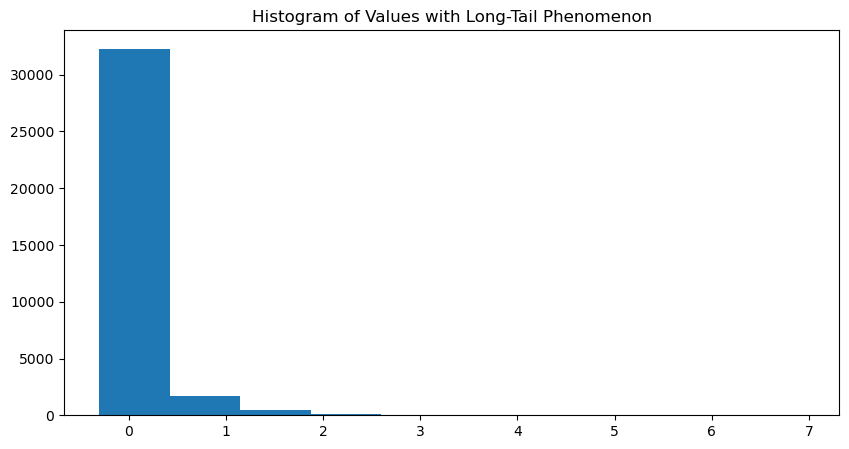

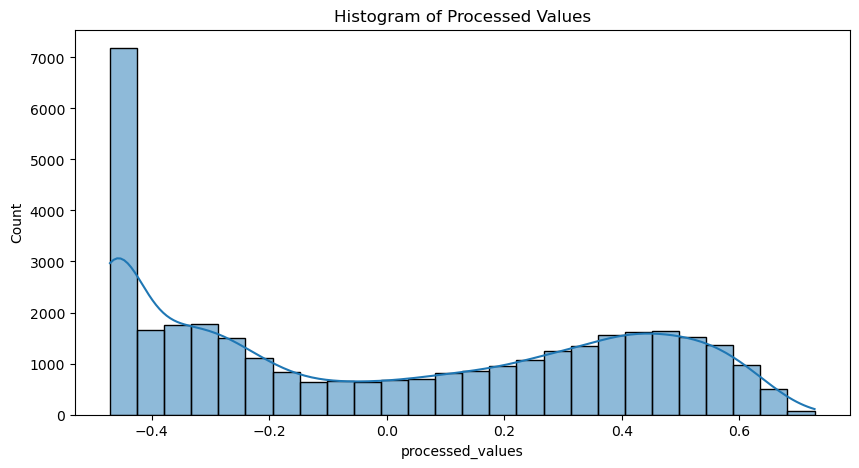

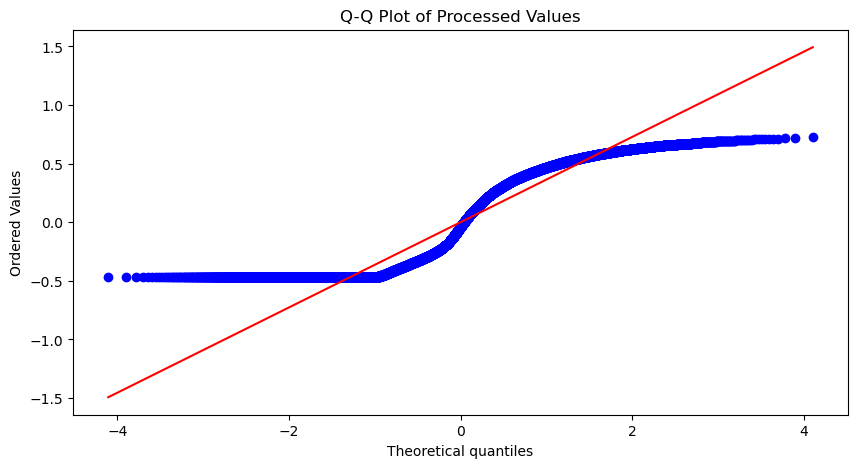

Skewness: 0.16795612155401707
K-S test statistics: 0.3188658983535325, p-value: 0.0
Shapiro-Wilk test statistics: 0.8871759176254272, p-value: 0.0


/opt/anaconda3/envs/research/lib/python3.11/site-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the file path
file_path = "/Users/cui/Library/CloudStorage/OneDrive-YaleUniversity/0 High-Dim Spatial/hubmap/ann/B009A_22_03_03_Skywalker_reg001_compensated_ann.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
# print(df)

# shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# pick a protein and drop the rows with missing values
protein = 'Vimentin'

df = df.dropna(subset=[protein])

# Graphical Analysis
# Histogram
plt.figure(figsize=(10, 5))
# sns.histplot(df[protein], kde=True)
plt.hist(df[protein])
plt.title('Histogram of Values with Long-Tail Phenomenon')
plt.show()


# apply log(\cdot + 1) to avoid the long-tail phenomenon
df[protein] = np.log(df[protein] + np.abs(df[protein].min())*2)
df[protein] = np.log(df[protein] + np.abs(df[protein].min())*2)
df[protein] = np.log(df[protein] + np.abs(df[protein].min())*2)
df[protein] = np.log(df[protein] + np.abs(df[protein].min())*2)
df[protein] = np.log(df[protein] + np.abs(df[protein].min())*2)
# df = df.drop(df[df[protein] < -10].index)
df[protein] = df[protein] - df[protein].mean()

# Assuming 'df' is your DataFrame and 'processed_values' is your transformed column

df['processed_values'] = df[protein]
 
# Graphical Analysis
# Histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['processed_values'], kde=True)
plt.title('Histogram of Processed Values')
plt.show()

# Q-Q Plot
plt.figure(figsize=(10, 5))
stats.probplot(df['processed_values'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Processed Values')
plt.show()

# Statistical Tests
# Skewness
skewness = stats.skew(df['processed_values'])
print(f'Skewness: {skewness}')

# Kolmogorov-Smirnov test
ks_stat, ks_pvalue = stats.kstest(df['processed_values'], 'norm')
print(f'K-S test statistics: {ks_stat}, p-value: {ks_pvalue}')

# Shapiro-Wilk test
shapiro_stat, shapiro_pvalue = stats.shapiro(df['processed_values'])
print(f'Shapiro-Wilk test statistics: {shapiro_stat}, p-value: {shapiro_pvalue}')


Vimentin is a structural protein that in humans is encoded by the VIM gene. Its name comes from the Latin vimentum which refers to an array of flexible rods.

Vimentin is a type III intermediate filament (IF) protein that is expressed in mesenchymal cells. IF proteins are found in all animal cells as well as bacteria. Intermediate filaments, along with tubulin-based microtubules and actin-based microfilaments, comprises the cytoskeleton. All IF proteins are expressed in a highly developmentally-regulated fashion; vimentin is the major cytoskeletal component of mesenchymal cells. Because of this, vimentin is often used as a marker of mesenchymally-derived cells or cells undergoing an epithelial-to-mesenchymal transition (EMT) during both normal development and metastatic progression.

# This looks reasonable but I am curious why skewness does not really compute.

/opt/anaconda3/envs/research/lib/python3.11/site-packages/gstools/field/plot.py:406: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


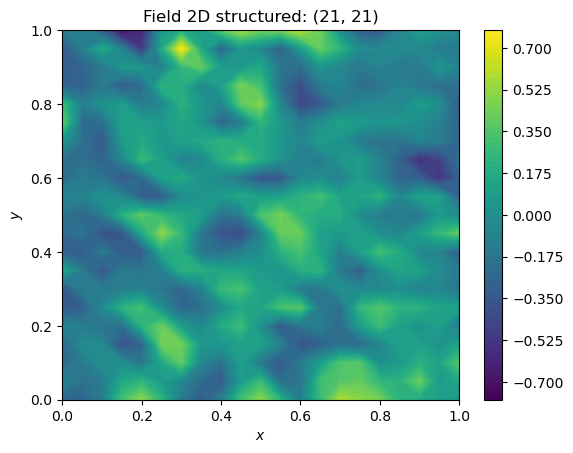

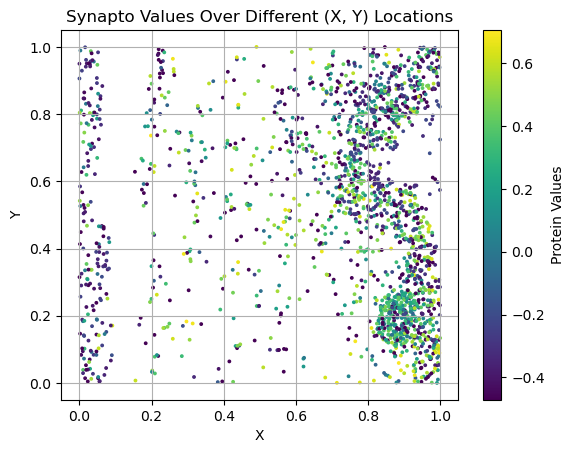

In [18]:
import numpy as np
import gstools as gs

# we normalise x and y so that the grid is approximately 1 by 1

df['x'] = df['x']/df['x'].max()
df['y'] = df['y']/df['y'].max()

# Let x and y be the your collections of x and y locations
x = df['x']  
y = df['y']  

# pick the training data set
df_train = df.head(2000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]


# define the covariance model - gaussian
cov_model = gs.Gaussian(
    # dim=2, len_scale=1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
    dim=2, len_scale=0.1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
)

# grid definition for output field
gridx = np.arange(0.0, 1.05, 0.05)
gridy = np.arange(0.0, 1.05, 0.05)

# perform the kriging and plot
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)



import matplotlib.pyplot as plt

# let us exhibit the two figure, the prediction and the original collection of values

EDK.structured([gridx, gridy])
EDK.plot()
plt.show()

# Plot the Synapto values over different (x, y) locations
# plt.figure(figsize=(8, 6))
plt.scatter(x_train, y_train, c=df_train[protein], cmap='viridis', s=3)  # Using 'viridis' colormap for better visualization
plt.colorbar(label='Protein Values')  # Add colorbar to show Synapto values
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synapto Values Over Different (X, Y) Locations')
plt.grid(True)
plt.show()


In [19]:
# pick the training data set
df_train = df.head(1000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.tail(100)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]

# define the covariance model - gaussian
cov_model = gs.Gaussian(
    # dim=2, len_scale=0.23, var=0.001, nugget=0.01
    dim=2, len_scale=0.1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
)

# perform the kriging
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)

val_pred,sigma = EDK([x_test,y_test])

# Calculate variance of the true values
mse = mean_squared_error(val_true, val_pred)

# Calculate normalized MSE
variance = np.var(val_true)
normalized_mse = mse / variance

print("Normalized MSE:", normalized_mse)

Normalized MSE: 1.156161685056277


# This is so obscenely high that I should just see if the model has learnt even the training set!

In [20]:
# pick the training data set
df_train = df.head(1000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.head(1000)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]

# define the covariance model - gaussian
cov_model = gs.Gaussian(
    # dim=2, len_scale=0.23, var=0.001, nugget=0.01
    dim=2, len_scale=0.1, anis=0.5, angles=-0.5, var=0.5, nugget=0.1
)

# perform the kriging
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)

val_pred,sigma = EDK([x_test,y_test])

# Calculate variance of the true values
mse = mean_squared_error(val_true, val_pred)

# Calculate normalized MSE
variance = np.var(val_true)
normalized_mse = mse / variance

print("Normalized MSE:", normalized_mse)

Normalized MSE: 0.6885737103527051


# This just makes things worse, so let us stick with 'Synapto'

# We have achieved
## 1. Learning the training data set (<0.1 error)
## 2. Tuning the parameters somewhat so that the test performance is better (<0.7 error)
## 3. I am starting to enjoy coding...

# Moving forward
## 1. Maybe giving the algorithm MORE data can help it do better predictions, but we need more computational power
## 2. It's not clear whether or not kriging usually requires a more serious algorithm for tuning the parameters.  Am I doing this correctly?
## 3. The long-tail phenomenon in the data has not been cleaned up, as evidenced by the hypothesis tests.  How do can we do it to pass the skewness and KS tests?
## 4. What about the other cov models?
## 5. Tests and preprocessing for stationarity, global trends.
## 6. Perhaps Semivariogram can be useful (see https://desktop.arcgis.com/en/analytics/case-studies/an-appropriate-kriging-model-for-soil-contamination.htm)

# Other Models
## 1. Cox processes packages require more computational power, and I should go register for an account.
## 2. We would like to find out whether it is A) the existing models have a limitation in multiple input columns because they did not think of such data sets would appear OR B) the kriging idea itself is limited to low dimensional data, but what kind of coding exercises can distinguish these two?



# Additional topics of discussion
## Admissions
## Slack
## High-Dim Stat, Low and Med Hanging fruits.

# Estimating the Effective Range

In [21]:
import skgstat as skg

# the data functions return a dict of 'sample' and 'description'
coordinates = x_train
values = val_train
V = skg.Variogram(coordinates=coordinates, values=values)
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   0.13
Sill:              0.15
Nugget:            0.00
        


In [22]:
import skgstat as skg

# the data functions return a dict of 'sample' and 'description'
coordinates = y_train
values = val_train
V = skg.Variogram(coordinates=coordinates, values=values)
print(V)

spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   0.14
Sill:              0.15
Nugget:            0.00
        


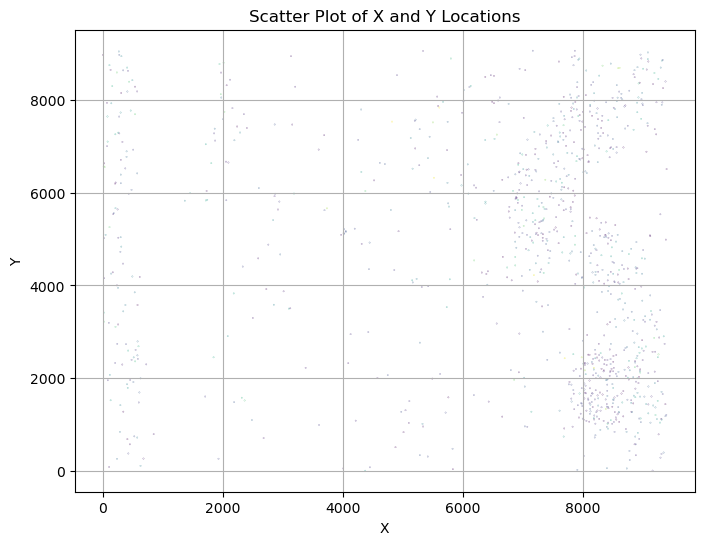

In [33]:
# Now I want to see if the algo. has learnt even the training set.
df_train = df.head(2000)
x_train = df_train['x']
y_train = df_train['y']
val_train = df_train[protein]
df_test = df.tail(1000)
x_test = df_test['x']
y_test = df_test['y']
val_true = df_test[protein]

parameters = [ 0.05830393,  1.36071891, -0.19030763,  1.05092486,  0.06536128]

# define the covariance model - gaussian
cov_model = gs.Gaussian(
    dim=2, len_scale=len_scale, anis=anis, angles=angles, var=var, nugget=nugget
)

# perform the kriging
EDK = gs.krige.Simple(
    model=cov_model, 
    cond_pos=(x_train, y_train), 
    cond_val=val_train,
)
val_pred,sigma = EDK([x_test,y_test])

error =  np.abs(val_true - val_pred)
error = error / error.max()

# let us get a sense of where these cell locations are.
import matplotlib.pyplot as plt
# Plot the x and y locations as dots
plt.figure(figsize=(8, 6))
plt.scatter(x_test, y_test, c=error, cmap='viridis', s=0.02)  # Adjust the color and size of the dots as needed
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of X and Y Locations')
plt.grid(True)
plt.show()

In [34]:
error

34961    0.448973
34962    0.443341
34963    0.089229
34964    0.000387
34965    0.107476
           ...   
36367    0.681765
36368    0.724463
36369    0.137991
36370    0.089823
36374    0.051910
Name: Synapto, Length: 1000, dtype: float64

In [41]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
iris = load_iris()
logistic = LogisticRegression(solver='saga', tol=1e-2, max_iter=200,
                              random_state=0)
distributions = dict(C=uniform(loc=0, scale=4),
                     penalty=['l2', 'l1'])
clf = RandomizedSearchCV(logistic, distributions, random_state=0)
search = clf.fit(iris.data, iris.target)
search.best_params_


{'C': 2.195254015709299, 'penalty': 'l1'}

In [49]:
search

RandomizedSearchCV(estimator=LogisticRegression(max_iter=200, random_state=0,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x15c889c50>,
                                        'penalty': ['l2', 'l1']},
                   random_state=0)